This is run by ResNet like architecture with first pooling layer adjustments

In [13]:
import numpy as np
import matplotlib.pyplot as plt

import sys
from pathlib import Path

#torch 
import torch
import torchvision as torchv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import Tensor
from torch.utils import data

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

In [14]:
#Metode for å hente data frå mappe
module_path = str(Path.cwd().parents[0].parents[0] / "methods")

if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader import *
# from plotCreator import *

data_path0 = str(Path.cwd().parents[0].parents[0] / "data" / "BH_n4_M10_res50_15000_events.h5")
data_path1 = str(Path.cwd().parents[0].parents[0] / "data" / "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res50_15000_events.h5")

In [15]:
#Hente data og sette til array
bhArray = dataToArray(data_path0)
sphArray = dataToArray(data_path1)

# print(bhArray.shape)
# print(sphArray.shape)

In [16]:
#Kombinerer dataene for å kunne kjøre gjennom modellen på et samlet datasett
dataArray = np.concatenate((bhArray,sphArray),axis=0)

In [17]:
# Labeler tabelle med 1 og 0 (0 = svart hull, 1 = spahleron)
labelsArray = np.concatenate((np.zeros(np.shape(bhArray)[0]),np.ones(np.shape(sphArray)[0])),axis=0)

In [18]:
#Sjekke om device GPU er på
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [19]:
#Split data 75% i train og 25% i test
trainData, testData, trainLabels, testLabels = train_test_split(dataArray, labelsArray, random_state=42)

In [20]:
#Transofrm from numpy array to torch
trainData = torch.from_numpy(trainData).permute(0,3,1,2)
testData = torch.from_numpy(testData).permute(0,3,1,2)
trainLabels = torch.from_numpy(trainLabels)
testLabels = torch.from_numpy(testLabels)

In [21]:
#Transformere numpy til tensor
train = torch.utils.data.TensorDataset(trainData, trainLabels)
test = torch.utils.data.TensorDataset(testData, testLabels)

In [22]:
#Transform data data to dataloader
trainLoader = DataLoader(train, shuffle=True, batch_size=50)
testLoader = DataLoader(test, shuffle=True, batch_size=50)

In [24]:
from torchsummary import summary
import nnmodel

model = nnmodel.VGGNet2(0.6).to(device)  # Move the model to the appropriate device

# Print the model summary, make sure to provide appropriate input size (3, 50, 50) for the 3-channel 50x50 images
summary(model, input_size=(3, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 50, 50]           1,792
       BatchNorm2d-2           [-1, 64, 50, 50]             128
              ReLU-3           [-1, 64, 50, 50]               0
            Conv2d-4           [-1, 64, 50, 50]          36,928
       BatchNorm2d-5           [-1, 64, 50, 50]             128
              ReLU-6           [-1, 64, 50, 50]               0
         MaxPool2d-7           [-1, 64, 25, 25]               0
           Dropout-8           [-1, 64, 25, 25]               0
            Conv2d-9          [-1, 128, 25, 25]          73,856
      BatchNorm2d-10          [-1, 128, 25, 25]             256
             ReLU-11          [-1, 128, 25, 25]               0
           Conv2d-12          [-1, 128, 25, 25]         147,584
      BatchNorm2d-13          [-1, 128, 25, 25]             256
             ReLU-14          [-1, 128,

Epoch: 0/50
Train Loss: 0.3162, Train Accuracy: 88.00%
Test Loss: 0.2229, Test Accuracy: 91.36%
Epoch: 1/50
Train Loss: 0.2487, Train Accuracy: 90.93%
Test Loss: 0.2525, Test Accuracy: 90.47%
Epoch: 2/50
Train Loss: 0.2376, Train Accuracy: 91.67%
Test Loss: 0.1825, Test Accuracy: 93.03%
Epoch: 3/50
Train Loss: 0.2231, Train Accuracy: 91.96%
Test Loss: 0.2005, Test Accuracy: 91.79%
Epoch: 4/50
Train Loss: 0.2169, Train Accuracy: 92.17%
Test Loss: 0.1838, Test Accuracy: 93.52%
Epoch: 5/50
Train Loss: 0.2144, Train Accuracy: 92.00%
Test Loss: 0.1898, Test Accuracy: 93.11%
Epoch: 6/50
Train Loss: 0.2058, Train Accuracy: 92.37%
Test Loss: 0.2074, Test Accuracy: 92.16%
Epoch 00007: reducing learning rate of group 0 to 5.0000e-04.
Epoch: 7/50
Train Loss: 0.1836, Train Accuracy: 93.28%
Test Loss: 0.1945, Test Accuracy: 92.08%
Epoch: 8/50
Train Loss: 0.1809, Train Accuracy: 93.28%
Test Loss: 0.2147, Test Accuracy: 92.12%
Epoch: 9/50
Train Loss: 0.1787, Train Accuracy: 93.52%
Test Loss: 0.1701, 

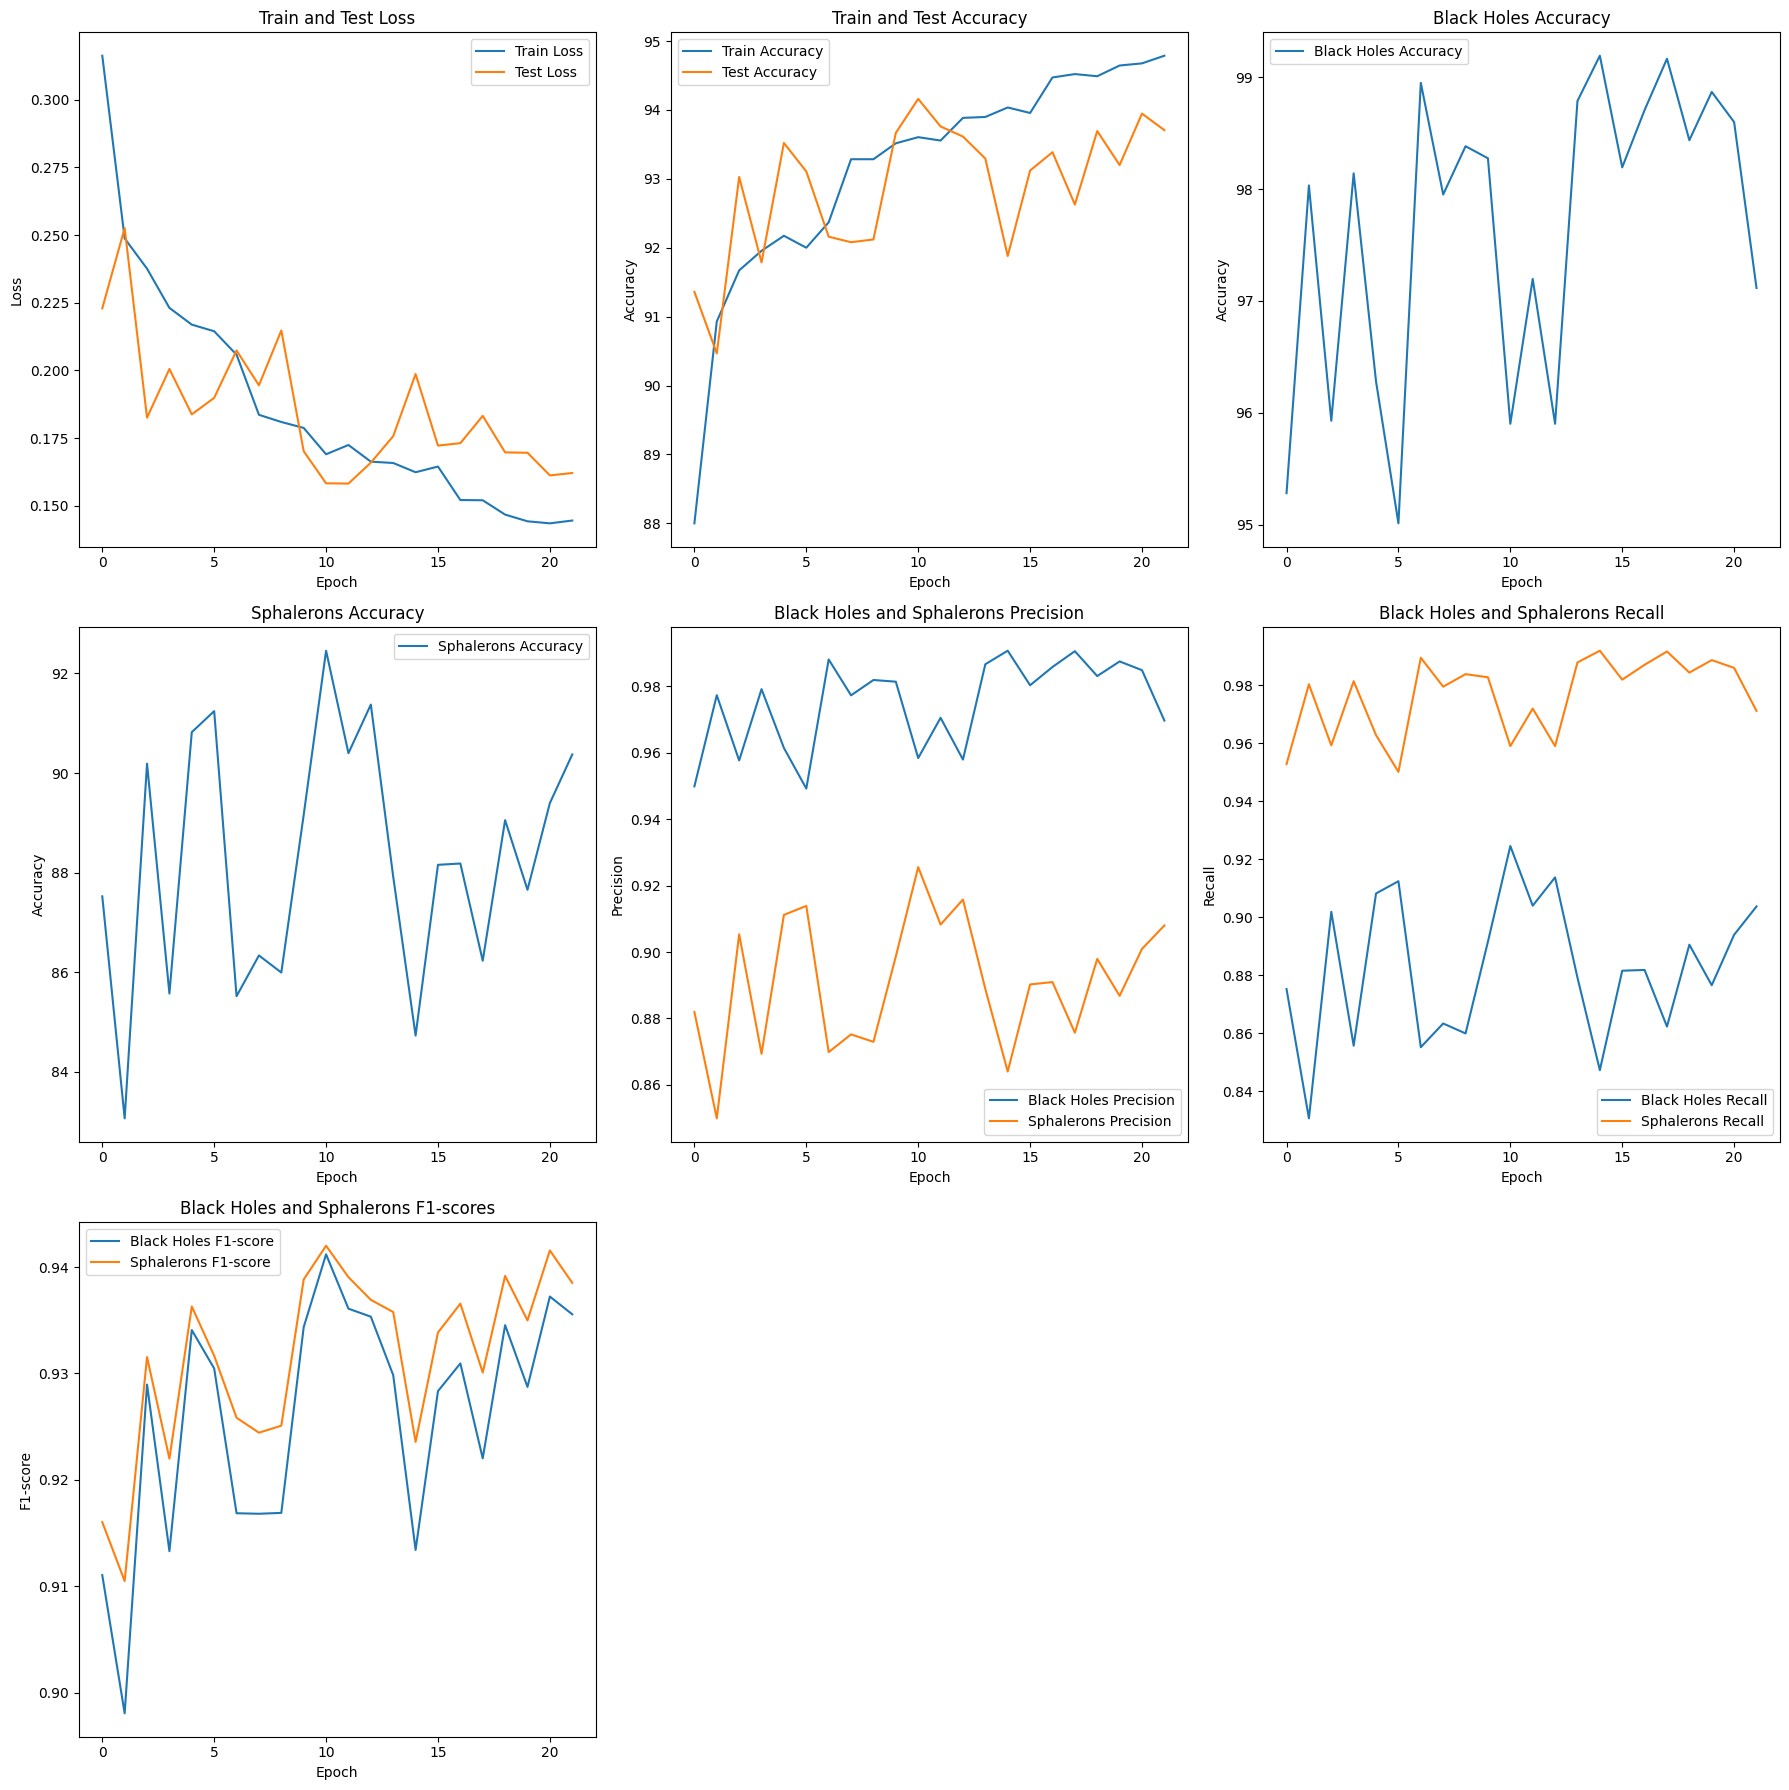

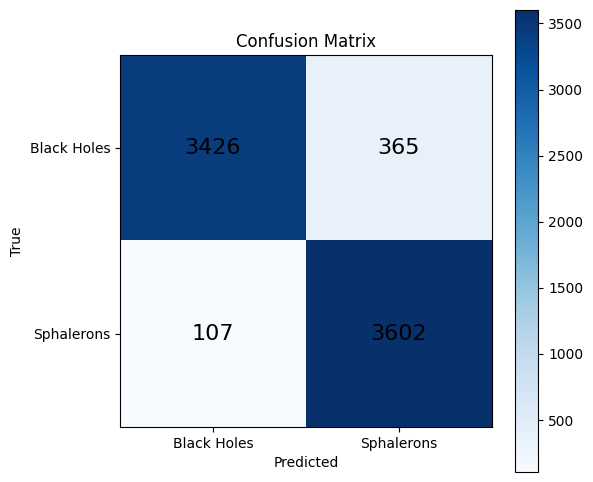

In [26]:
import trainer
# Set the learning rate and number of epochs
n_epochs = 10

# Create the model
model = nnmodel.VGGNet2(0.6).to(device)

# Set up the optimizer and criterion
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss().to(device)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True, factor=0.5)

# Train the model
trainer.train(model, trainLoader, testLoader, optimizer, criterion, n_epochs, scheduler = scheduler, early_stopping_patience = 10)